In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, History
from sklearn.metrics import r2_score
from PrepareDataset import PrepareDataset

import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('dataset/dataset.csv', header=0)

In [3]:
dataset = PrepareDataset(dataset=data)
dataset = dataset.early_preparation()
dataset = dataset.set_rows_to_zeros()
dataset = dataset.split_power()
dataset = dataset.standard_scaled_dataset()

In [4]:
train_dataset = dataset.train()
val_dataset = dataset.val()
test_dataset = dataset.test()

In [5]:
tf.random.set_seed(10)
model = Sequential()
model.add(LSTM(32, return_sequences=True, input_shape=(11, 1)))
model.add(LSTM(64, activation='relu'))
model.add(Dense(64))
model.add(Dense(1))

In [6]:
model.compile(loss='mse', optimizer=Adam(0.001))

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 11, 32)            4352      
                                                                 
 lstm_1 (LSTM)               (None, 64)                24832     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 33,409
Trainable params: 33,409
Non-trainable params: 0
_________________________________________________________________


In [8]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=0)
model_checkpoint = ModelCheckpoint('LSTMModel.h5', verbose=0, save_best_only=True)
history = History()

In [9]:
model.fit(train_dataset[0], train_dataset[1], epochs=50, validation_data=(val_dataset[0], val_dataset[1]),
                                              callbacks=[early_stopping, model_checkpoint, history], batch_size=2, verbose=0)

In [10]:
loss = np.array(history.history['loss'])
val_loss = np.array(history.history['val_loss'])

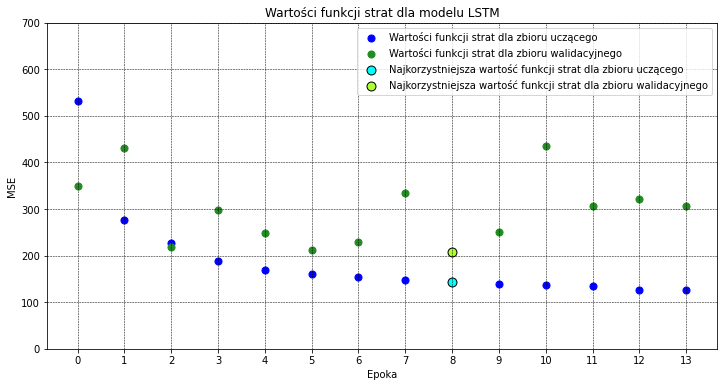

In [11]:
plt.scatter(range(len(loss)), loss, color='blue', label='Wartości funkcji strat dla zbioru uczącego', s=50)
plt.scatter(range(len(val_loss)), val_loss, color='forestgreen', label='Wartości funkcji strat dla zbioru walidacyjnego', s=50)
plt.scatter(np.argmin(val_loss), loss[np.argmin(val_loss)], color='cyan', edgecolors='black',
                                                            label='Najkorzystniejsza wartość funkcji strat dla zbioru uczącego', s=80)
plt.scatter(np.argmin(val_loss), np.min(val_loss), color='greenyellow', edgecolors='black',
                                                            label='Najkorzystniejsza wartość funkcji strat dla zbioru walidacyjnego', s=80)
fig = plt.gcf()
fig = fig.set_size_inches(12,6)
plt.xticks(range(len(loss)))
plt.yticks([i * 100 for i in range(0, 8)])
plt.grid(color='k', linewidth=0.5, linestyle='--')
plt.title('Wartości funkcji strat dla modelu LSTM')
plt.xlabel('Epoka')
plt.ylabel('MSE')
plt.legend(loc='best')
plt.show()

In [12]:
model.load_weights('LSTMModel.h5')

In [13]:
predictions = model.predict(test_dataset[0], verbose=0)[:,0]

In [14]:
print(f'R^2 score: {round(r2_score(test_dataset[1], predictions), 3)}')
print(f'R score: {round(np.sqrt(r2_score(test_dataset[1], predictions)), 3)}')

R^2 score: 0.761
R score: 0.872


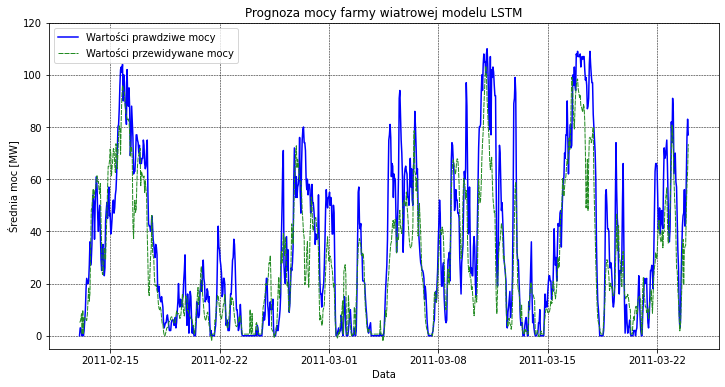

In [15]:
plt.plot(dataset.date_time[int(dataset.lenght * 0.9):], test_dataset[1], color='blue', label='Wartości prawdziwe mocy', linewidth=1.5)
plt.plot(dataset.date_time[int(dataset.lenght * 0.9):], predictions, color='forestgreen',
                                                                     linestyle=(0, (5, 1)), label='Wartości przewidywane mocy', linewidth=1)
fig = plt.gcf()
fig = fig.set_size_inches(12,6)
plt.ylim([-5, 120])
plt.ticklabel_format(axis='y', style='plain')
plt.grid(color='k', linewidth=0.5, linestyle='--')
plt.title('Prognoza mocy farmy wiatrowej modelu LSTM')
plt.xlabel('Data')
plt.ylabel('Średnia moc [MW]')
plt.legend(loc='best')
plt.show()

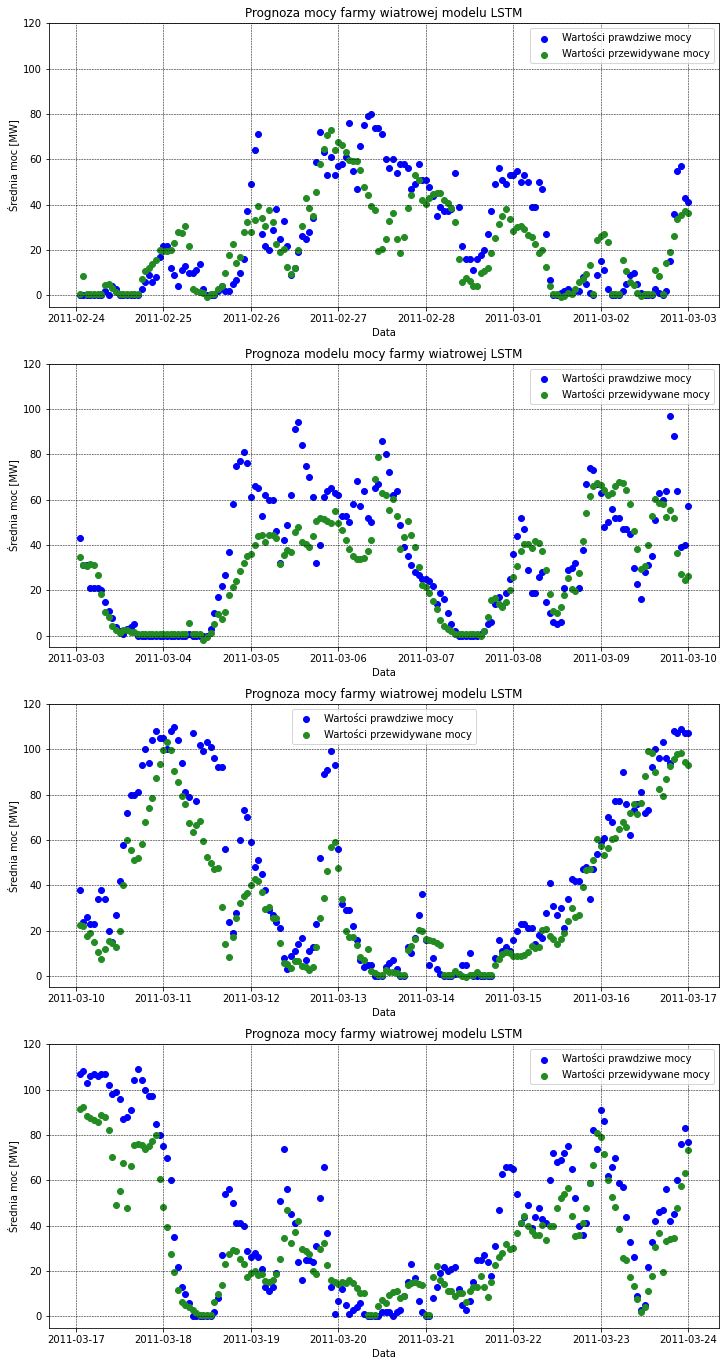

In [16]:
fig, (ax0, ax1, ax2, ax3) = plt.subplots(4, 1, figsize=(12,24))
ax3.scatter(dataset.date_time[-168:], test_dataset[1][-168:], color='blue', label='Wartości prawdziwe mocy')
ax3.scatter(dataset.date_time[-168:], predictions[-168:], color='forestgreen', label='Wartości przewidywane mocy')
ax3.set_ylim([-5, 120])
ax3.ticklabel_format(axis='y', style='plain')
ax3.grid(color='k', linewidth=0.5, linestyle='--')
ax3.set_title('Prognoza mocy farmy wiatrowej modelu LSTM')
ax3.set_xlabel('Data')
ax3.set_ylabel('Średnia moc [MW]')
ax3.legend(loc='best')

ax2.scatter(dataset.date_time[-336:-168], test_dataset[1][-336:-168], color='blue', label='Wartości prawdziwe mocy')
ax2.scatter(dataset.date_time[-336:-168], predictions[-336:-168], color='forestgreen', label='Wartości przewidywane mocy')
ax2.set_ylim([-5, 120])
ax2.ticklabel_format(axis='y', style='plain')
ax2.grid(color='k', linewidth=0.5, linestyle='--')
ax2.set_title('Prognoza mocy farmy wiatrowej modelu LSTM')
ax2.set_xlabel('Data')
ax2.set_ylabel('Średnia moc [MW]')
ax2.legend(loc='best')

ax1.scatter(dataset.date_time[-504:-336], test_dataset[1][-504:-336], color='blue', label='Wartości prawdziwe mocy')
ax1.scatter(dataset.date_time[-504:-336], predictions[-504:-336], color='forestgreen', label='Wartości przewidywane mocy')
ax1.set_ylim([-5, 120])
ax1.ticklabel_format(axis='y', style='plain')
ax1.grid(color='k', linewidth=0.5, linestyle='--')
ax1.set_title('Prognoza modelu mocy farmy wiatrowej LSTM')
ax1.set_xlabel('Data')
ax1.set_ylabel('Średnia moc [MW]')
ax1.legend(loc='best')

ax0.scatter(dataset.date_time[-672:-504], test_dataset[1][-672:-504], color='blue', label='Wartości prawdziwe mocy')
ax0.scatter(dataset.date_time[-672:-504], predictions[-672:-504], color='forestgreen', label='Wartości przewidywane mocy')
ax0.set_ylim([-5, 120])
ax0.ticklabel_format(axis='y', style='plain')
ax0.grid(color='k', linewidth=0.5, linestyle='--')
ax0.set_title('Prognoza mocy farmy wiatrowej modelu LSTM')
ax0.set_xlabel('Data')
ax0.set_ylabel('Średnia moc [MW]')
ax0.legend(loc='best')

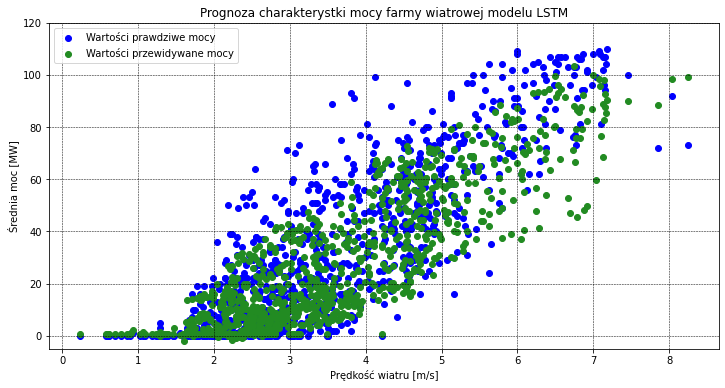

In [17]:
plt.scatter(dataset.wind_speed[int(dataset.lenght * 0.9):], test_dataset[1], color='blue', label='Wartości prawdziwe mocy')
plt.scatter(dataset.wind_speed[int(dataset.lenght * 0.9):], predictions, color='forestgreen', label='Wartości przewidywane mocy')
fig = plt.gcf()
fig = fig.set_size_inches(12,6)
plt.ylim([-5, 120])
plt.ticklabel_format(axis='y', style='plain')
plt.grid(color='k', linewidth=0.5, linestyle='--')
plt.title('Prognoza charakterystki mocy farmy wiatrowej modelu LSTM')
plt.xlabel('Prędkość wiatru [m/s]')
plt.ylabel('Średnia moc [MW]')
plt.legend(loc='best')
plt.show()